In [1]:
import tensorflow as tf
import numpy as np
import os.path
import joblib
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPool2D, Add, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Imported the neccessary libraries

2023-04-04 02:51:55.041112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 02:51:55.236913: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-04 02:51:55.266427: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-04 02:51:55.266451: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [3]:
import os
import shutil
import glob
import random

def copy_files_70_30_percent(): #copy files from one location to another
    os.chdir(os.path.dirname(os.path.abspath('model_alzheimers_cnn.ipynb')))
    
    if os.path.isdir('model_data') is False:
        os.makedirs('model_data/train/axial/AD')
        os.makedirs('model_data/train/coronal/AD')
        os.makedirs('model_data/train/sagittal/AD')
        os.makedirs('model_data/train/axial/CN')
        os.makedirs('model_data/train/coronal/CN')
        os.makedirs('model_data/train/sagittal/CN')
        os.makedirs('model_data/train/axial/MCI')
        os.makedirs('model_data/train/coronal/MCI')
        os.makedirs('model_data/train/sagittal/MCI')
        os.makedirs('model_data/valid/axial/AD')
        os.makedirs('model_data/valid/coronal/AD')
        os.makedirs('model_data/valid/sagittal/AD')
        os.makedirs('model_data/valid/axial/CN')
        os.makedirs('model_data/valid/coronal/CN')
        os.makedirs('model_data/valid/sagittal/CN')
        os.makedirs('model_data/valid/axial/MCI')
        os.makedirs('model_data/valid/coronal/MCI')
        os.makedirs('model_data/valid/sagittal/MCI')
        
        #creates a directory named model_data and several subdirectories with different names and
        # paths representing the classes and image orientations used for training and validation of a machine learning model, 
        # if the model_data directory does not exist already.
        
        # get current directory
        print(os.getcwd())
        for view in ['axial', 'coronal', 'sagittal']:
            # os.chdir('../')
            all_ad_files = glob.glob(f'Processed_MRI/augmented/AD/{view}/*')
            all_cn_files = glob.glob(f'Processed_MRI/augmented/CN/{view}/*')
            all_mci_files = glob.glob(f'Processed_MRI/augmented/MCI/{view}/*')
            
            print(len(all_ad_files))

            num_ad_files = len(all_ad_files)
            num_cn_files = len(all_cn_files)
            num_mci_files = len(all_mci_files)

            num_ad_train = int(0.7 * num_ad_files)
            num_cn_train = int(0.7 * num_cn_files)
            num_mci_train = int(0.7 * num_mci_files)

            ad_train_files = random.sample(all_ad_files, num_ad_train)
            cn_train_files = random.sample(all_cn_files, num_cn_train)
            mci_train_files = random.sample(all_mci_files, num_mci_train)

            ad_valid_files = list(set(all_ad_files) - set(ad_train_files))
            cn_valid_files = list(set(all_cn_files) - set(cn_train_files))
            mci_valid_files = list(set(all_mci_files) - set(mci_train_files))
            
            #randomly divides augmented MRI files into training and validation sets for each class and image orientation, 
            # and prints the number of files in the classes

            # print(os.getcwd())
            # os.chdir('code')
            for c in ad_train_files:
                shutil.copy(c, f'model_data/train/{view}/AD')
            for c in cn_train_files:
                shutil.copy(c, f'model_data/train/{view}/CN')
            for c in mci_train_files:
                shutil.copy(c, f'model_data/train/{view}/MCI')

            for c in ad_valid_files:
                shutil.copy(c, f'model_data/valid/{view}/AD')
            for c in cn_valid_files:
                shutil.copy(c, f'model_data/valid/{view}/CN')
            for c in mci_valid_files:
                shutil.copy(c, f'model_data/valid/{view}/MCI')


In [4]:
copy_files_70_30_percent()

In [5]:
train_path = 'model_data/train/axial'
valid_path = 'model_data/valid/axial'

## Use the vgg16 prepocesser to preprocess the images which resizes and reshapes the images to feed the model

In [6]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=10, classes=['AD', 'CN', 'MCI'])
 
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=10, classes=['AD', 'CN','MCI'], shuffle=False)

Found 1350 images belonging to 3 classes.
Found 580 images belonging to 3 classes.


In [7]:
# assert train_batches.n == 1341
# assert valid_batches.n == 576

In [8]:
imgs, labels = next(train_batches)

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## Filters

The higher the number of filters, the higher the number of abstractions that your Network is able to extract from image data. The reason why the number of filters is generally ascending is that at the input layer the Network receives raw pixel data. Raw data are always noisy, and this is especially true for image data.

Because of this, we let CNNs extract first some relevant information from noisy, "dirty" raw pixel data. Once the useful features have been extracted, then we make the CNN elaborate more complex abstractions on it.

That is why the number of filters usually increases as the Network gets deeper, even though it doesn't necessarily have to be like that.


## Kernel Size

Convolutional neural networks work on 2 assumptions -

Low level features are local
What's useful in one place will also be useful in other places
Kernel size should be determined by how strongly we believe in those assumptions for the problem at hand.

In one extreme case where we have 1x1 kernels, we are essentially saying low level features are per-pixel, and they don't affect neighbouring pixels at all, and that we should apply the same operation to all pixels.

In the other extreme, we have kernels the size of the entire image. In this case the CNN essentially becomes fully connected, and stops being a CNN, and we are no longer making any assumption on low level feature locality.

In [10]:
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


def residual_block(inputs, num_filters): #defines a residual block for use in a convolutional neural network
    x = Conv2D(filters=num_filters, kernel_size=(3,3), padding='same')(inputs)
    x = BatchNormalization()(x) #Batch normalization is used here for neural networks to improve the training speed and 
    #stability by normalizing the input layer by adjusting and scaling the activations.
    x = Activation('relu')(x) #ReLU is used as an activation function to introduce non-linearity into the output of this neural network layer.
    x = Conv2D(filters=num_filters, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    if inputs.shape[-1] != num_filters:
        shortcut = Conv2D(num_filters, (1, 1), padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = inputs
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

input_tensor = Input(shape=(224, 224, 3)) #first two dimensions (224, 224) represent the height and width of the input image, respectively, 
#while the last dimension (3) represents the number of color channels (red, green, and blue) for each pixel in the image.
x = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(input_tensor)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = residual_block(x, num_filters=32)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = residual_block(x, num_filters=64)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = residual_block(x, num_filters=128)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = residual_block(x, num_filters=256)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = residual_block(x, num_filters=512)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = Flatten()(x) # to convert the output tensor from the convolutional layers to a 1D tensor, which can be fed into the fully connected layers.
x = Dense(units=256, activation='relu')(x) # Dense is a fully connected layer in a neural network, connected to 256 neurons 
x = Dropout(0.25)(x) #Dropout layer with a rate of 0.25 which results in 25% of the input units dropping.
output_tensor = Dense(units=3, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

#MaxPooling2D is used to reduce the spatial dimensions of the output of each convolutional layer in order to make the network computationally less expensive
# and to prevent overfitting.


2023-03-23 01:22:09.985948: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-23 01:22:09.986003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (divya-Inspiron-15-5518): /proc/driver/nvidia/version does not exist
2023-03-23 01:22:09.986879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot_cnn_multi.png', show_shapes=True, show_layer_names=True)

#Plotting the architecture. 

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 112, 112, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [58]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

##using the Adam optimizer with a learning rate of 0.0001, categorical cross-entropy as the loss function,
# and accuracy as the metric to be monitored during training.

In [59]:
from keras.callbacks import LearningRateScheduler

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

def lr_schedule(epoch):
    lr = 0.0001
    if epoch > 20:
        lr *= 0.1
    return lr
##The learning rate scheduler adjusts the learning rate of the Adam optimizer based on the epoch number, reducing it by a factor of 10 after 20 epochs. 

if os.path.isfile('models/simple_model_multi.h5'):
    model = load_model('models/simple_model_multi.h5')
    history = joblib.load('models/history/simple_model_history_multi.pkl')
else:
    history = model.fit(x=train_batches, validation_data=valid_batches, epochs=50, verbose=2, callbacks=[callback, LearningRateScheduler(lr_schedule)])
    joblib.dump(history, 'models/history/simple_model_history_multi.pkl')
    
    model.save('models/simple_model_multi.h5')
    
    #the model is trained for 50 epochs on the training and validation data, 
# with the early stopping and learning rate scheduler callbacks applied, and the model and history are saved to the file system.    

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-03-20 22:44:46     73213376
metadata.json                                  2023-03-20 22:44:46           64
config.json                                    2023-03-20 22:44:46        25545
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......activation_4
.........vars
......activation_5
.........vars
......activation_6
.........vars
......activation_7
.........vars
......activation_8
.........vars
......activation_9
.........vars
......add
.........vars
......add_1
.........vars
......add_2
.........vars
......add_3
.........vars
......add_4
.........vars
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalizati

# Tracking Convergence

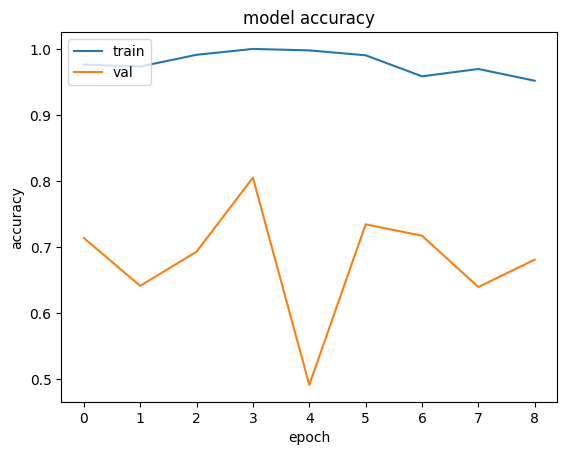

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


#plots the accuracy of the model over epochs on both training and validation data. 
#It helps visualize the performance of the model and identify overfitting or underfitting

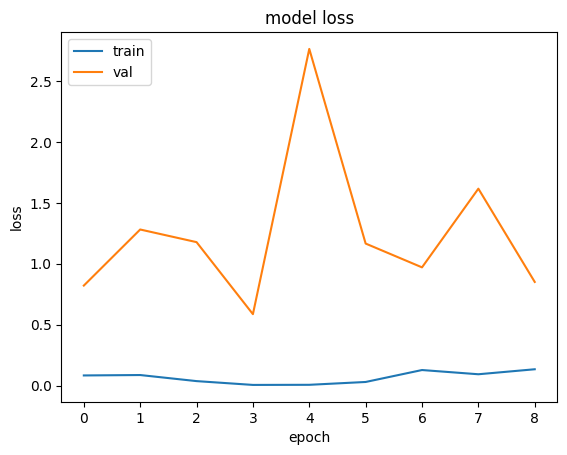

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#plots the training and validation loss of a machine learning model over epochs to visualize overfitting or underfitting.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

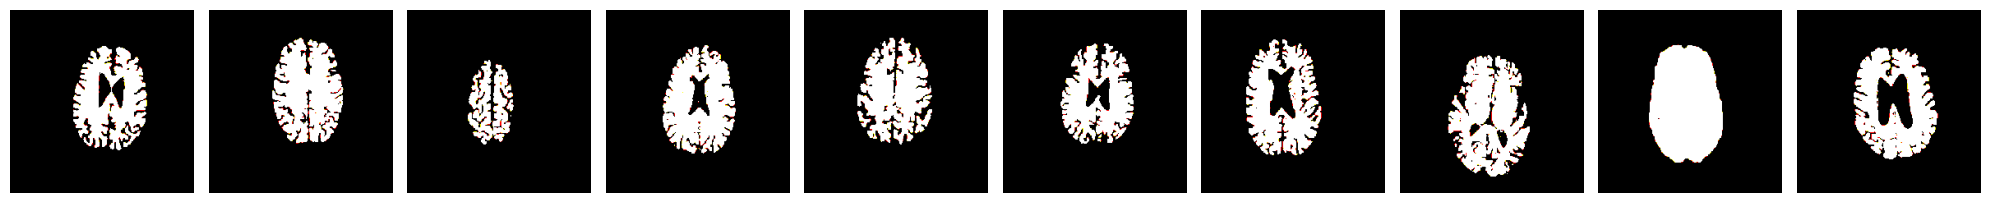

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [62]:
test_imgs, test_labels = next(valid_batches)
plotImages(test_imgs)
print(test_labels)

#examine the group of test images together with their corresponding labels.

In [63]:
predictions = model.predict(x=valid_batches, verbose=0)

# generates predictions for a set of data called valid_batches and saves the predictions in a variable named 'predictions' for future evaluation.

In [64]:
np.round(predictions)

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [65]:
test_imgs, test_labels = next(valid_batches)

In [66]:
test_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [67]:
import os
from tensorflow.keras.preprocessing.image import load_img

# Get the list of file names in the directory
file_names_ad = os.listdir(train_path + "/AD")

# Select the first file name from the list
first_file_name = file_names_ad[0]

# Load the first image
ad = load_img(train_path + "/AD/" + first_file_name)

# Get the list of file names in the directory
file_names_cn = os.listdir(train_path + "/CN")

# Select the first file name from the list
first_file_name = file_names_cn[0]

# Load the first image
cn = load_img(train_path + "/CN/" + first_file_name)

file_names_ad = os.listdir(train_path + "/MCI")

first_file_name = file_names_ad[0]

mci = ad = load_img(train_path + "/MCI/" + first_file_name)



In [68]:
# Preprocess the images using VGG16 preprocessing function
ad_processed = tf.keras.applications.vgg16.preprocess_input(np.array(ad.resize((224, 224))))
cn_processed = tf.keras.applications.vgg16.preprocess_input(np.array(cn.resize((224, 224))))
mci_processed = tf.keras.applications.vgg16.preprocess_input(np.array(mci.resize((224, 224))))

# Create a batch of size 2 with the processed images
visualize_batch = np.stack([ad_processed, cn_processed, mci_processed])



In [69]:
visualize_batch[0].shape

(224, 224, 3)

In [13]:
len(model.layers)

55

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


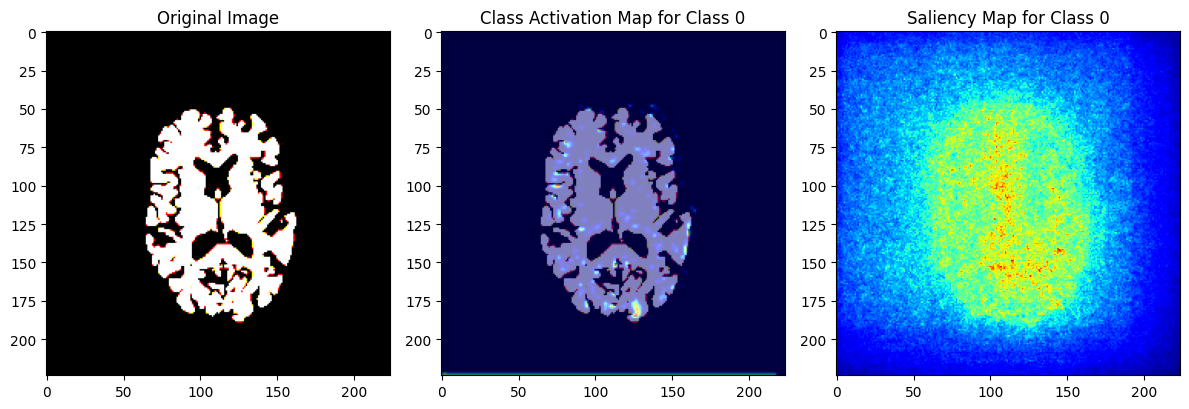

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


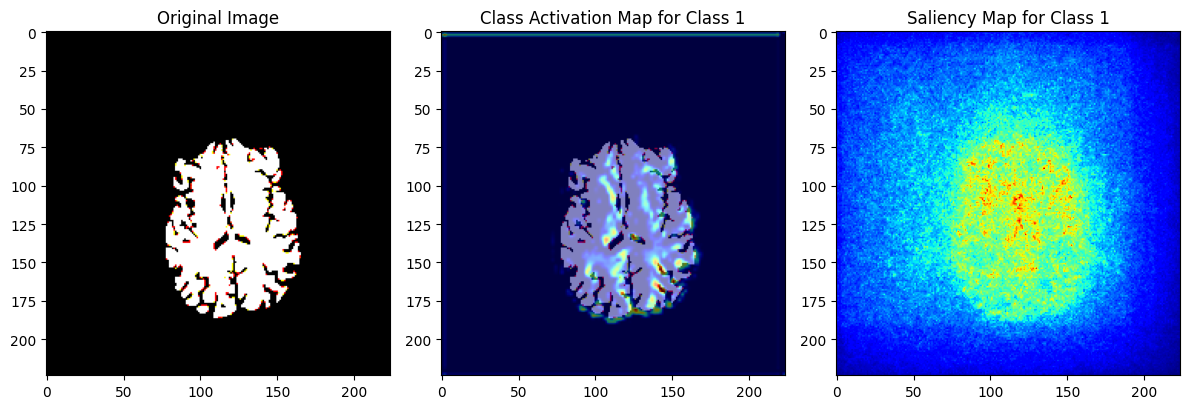

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


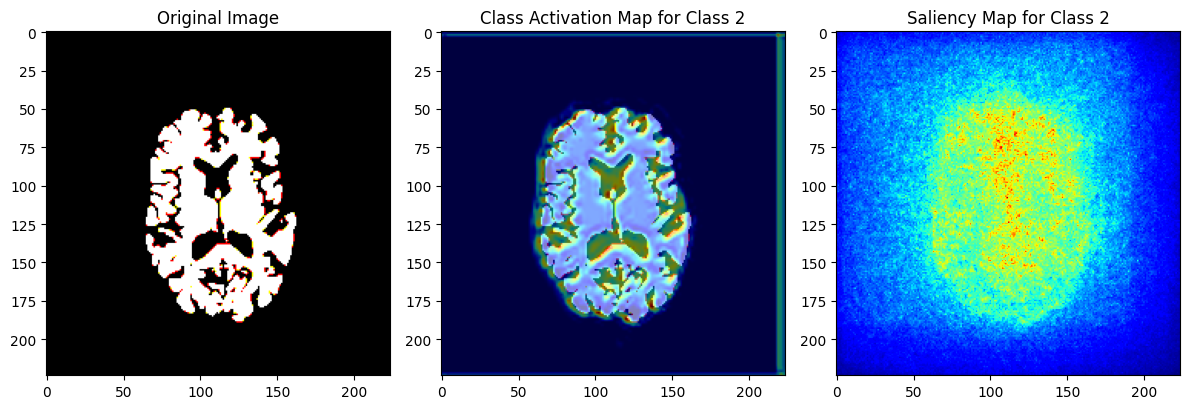

In [79]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
replace2linear = ReplaceToLinear() 

# Select an image from the validation set



batch = valid_batches
# gradcam_model = tf.keras.models.Model(
#     [model.inputs], [model.layers[-3].output, model.output]
# )
# Create GradCAM++ object
# Create Gradcam object
gradcam = GradcamPlusPlus(model,         
                  model_modifier=replace2linear,
                  clone=True)

# Create Saliency object.  
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map 

# Loop over all classes and generate corresponding heatmaps
for class_index in range(len(valid_batches.class_indices)):
    # error = True
    # image_index = np.where(visualize_batch.classes == class_index)[0][0]
    image = visualize_batch[class_index]
    # Generate cam with GradCAM++
    cam = gradcam(CategoricalScore(class_index), image, penultimate_layer=10)
    saliency_map = saliency(CategoricalScore(class_index), image, smooth_samples=20, smooth_noise=0.20) # noise spread level.)
    
    # Plot the original image and the heatmap
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    axs[1].imshow(image)
    axs[1].imshow(heatmap, alpha=0.5, cmap='jet')
    axs[1].set_title(f'Class Activation Map for Class {class_index}')
    
    axs[2].imshow(saliency_map[0], cmap='jet')
    axs[2].set_title(f'Saliency Map for Class {class_index}')
    plt.tight_layout()
    plt.show()



In [71]:
cm = confusion_matrix(y_true=valid_batches.classes, y_pred=np.argmax(predictions, axis=1))

In [72]:

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
  #This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}%".format(cm[i, j] * 100),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # creates a confusion matrix plot with options to normalize the values and display percentages for each cell. 
    # The function takes the confusion matrix, a list of class labels, and a title as input. The function also sets the axis labels and displays a colorbar.

In [73]:
valid_batches.class_indices

{'AD': 0, 'CN': 1, 'MCI': 2}

Confusion matrix for the model is shown below, where the diagonal elements are the true positives, the off-diagonal elements are the false positives.

Normalized confusion matrix
[[0.6        0.16       0.24      ]
 [0.04022989 0.8908046  0.06896552]
 [0.01779359 0.13879004 0.84341637]]


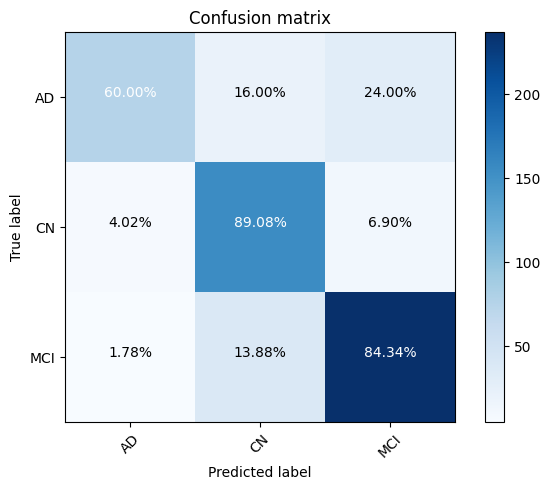

In [74]:
cm_plot_labels = valid_batches.class_indices.keys()
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix', normalize= True)

#Plotting confusing matrix for multi-class

In [75]:
from sklearn import metrics

print(metrics.classification_report(valid_batches.classes, np.argmax(predictions, axis=-1), target_names=cm_plot_labels))

#generating a report which includes various metrics such as precision, recall, f1-score, and support for each class. 

              precision    recall  f1-score   support

          AD       0.86      0.60      0.71       125
          CN       0.72      0.89      0.80       174
         MCI       0.85      0.84      0.85       281

    accuracy                           0.81       580
   macro avg       0.81      0.78      0.78       580
weighted avg       0.81      0.81      0.80       580

